# Train Audio Neural Network

## Connect to Google Drive

In [1]:
# File manipulation imports for Google Colab
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir("/content/drive/My Drive/Colab Notebooks/CSCI535")

Mounted at /content/drive


## Imports

TRILL: https://aihub.cloud.google.com/u/0/p/products%2F186e4836-0280-4bf0-9ca5-006eed0265fb  
wav2vec2: https://huggingface.co/docs/transformers/model_doc/wav2vec2

In [2]:
!pip install --quiet transformers 
!pip install --quiet torchinfo
!pip install --quiet adabelief-pytorch
!pip install --quiet pydub
#!pip install --quiet audiomentations
!pip install --quiet torch_audiomentations
# !pip install --quiet swifter
# !pip install --quiet cloud-tpu-client

     |████████████████████████████████| 4.0 MB 15.1 MB/s 
     |████████████████████████████████| 6.6 MB 61.1 MB/s 
     |████████████████████████████████| 77 kB 9.0 MB/s 
     |████████████████████████████████| 895 kB 64.5 MB/s 
     |████████████████████████████████| 596 kB 81.4 MB/s 
     |████████████████████████████████| 58 kB 7.6 MB/s 


In [3]:
# Data Manipulation
import pandas as pd
import numpy as np
from glob import glob
import json
# import swifter

# Audio
import pydub
import torchaudio
torchaudio.sox_effects.init_sox_effects()
import IPython # IPython.display.Audio
#from audiomentations import Compose, PitchShift, Gain, PolarityInversion, Shift, AddGaussianNoise, TimeStretch
from torch_audiomentations import Compose, PitchShift, Gain, PolarityInversion, Shift #AddGaussianNoise, TimeStretch

# Neural Networks
import torch
import torch.nn as nn
from torchinfo import summary
from adabelief_pytorch import AdaBelief
from transformers import Wav2Vec2FeatureExtractor, WavLMModel, WavLMConfig
import tensorflow as tf
assert tf.executing_eagerly()
import tensorflow_hub as hub

# Metrics
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix, precision_recall_curve 
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Auxilary
from tqdm import tqdm
from copy import deepcopy
from typing import Tuple
import time
import copy

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline
import pylab

## Config

In [4]:
# Audio Preprocessing
SAMPLING_RATE = 16000
MAX_AUDIO_LENGTH = int(6 * SAMPLING_RATE)
STEP_SIZE = int(SAMPLING_RATE * 0.010)
WINDOW_SIZE = int(SAMPLING_RATE * 0.025)
TIMESTEPS = int(MAX_AUDIO_LENGTH/STEP_SIZE)
NUM_MELS = 256
NUM_MFCCS = 128

# Neural Network
PRETRAINED = 'wavlm'
if PRETRAINED == 'wav2vec2': EMBEDDING_SIZE = WINDOW_SIZE
elif PRETRAINED == 'trill': EMBEDDING_SIZE = 2048
elif PRETRAINED == 'wavlm': EMBEDDING_SIZE = WINDOW_SIZE
elif PRETRAINED == 'melspectrogram': EMBEDDING_SIZE = NUM_MELS
elif PRETRAINED == 'mfcc': EMBEDDING_SIZE = NUM_MFCCS
elif PRETRAINED == None: EMBEDDING_SIZE = WINDOW_SIZE
else: raise Exception('Invalid choice for pre-trained')
BATCH_SIZE = 64
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'Device: {DEVICE}')

Device: cuda:0


## Load Transformer

In [5]:
# Load pre-trained model
if PRETRAINED == 'wav2vec2':
    wav2vec2 = Wav2Vec2FeatureExtractor(feature_size=EMBEDDING_SIZE, sampling_rate=SAMPLING_RATE, do_normalize=True)
    wav2vec2.from_pretrained('facebook/wav2vec2-large-960h')
elif PRETRAINED == 'trill':
    trill = hub.load('https://tfhub.dev/google/nonsemantic-speech-benchmark/trill-distilled/3')
elif PRETRAINED == 'wavlm':
    # WavLM = WavLMModel(WavLMConfig())
    # WavLM.from_pretrained('microsoft/wavlm-large')
    WavLM = Wav2Vec2FeatureExtractor(feature_size=EMBEDDING_SIZE, sampling_rate=SAMPLING_RATE, do_normalize=True)
    WavLM.from_pretrained('microsoft/wavlm-large')
elif PRETRAINED == 'melspectrogram':
    pass
elif PRETRAINED == 'mfcc':
    pass
elif PRETRAINED == None:
    pass
else:
    raise Exception('PRETRAINED must be one of: trill, wav2vec2')

Downloading:   0%|          | 0.00/214 [00:00<?, ?B/s]

## Load Labels

In [6]:
# Get filepath for all labeling files
files = set()
for session_num in range(1, 6):
    path = f'IEMOCAP_full_release/Session{session_num}/dialog/EmoEvaluation'
    files.update(glob(path+'/*.txt'))

In [7]:
# Load labels from files
labels = dict()
for file in tqdm(files):
    with open(file, 'r') as f_in:
        for idx, line in enumerate(f_in.readlines()):
            line = line.split('\t')
            if len(line) > 3: 
                labels[line[1]] = line[2]
print(f'\n' + 'Got {len(labels)} labels.')

100%|██████████| 151/151 [01:15<00:00,  2.01it/s]


Got {len(labels)} labels.


On IEMOCAP class merging:  
https://ec.europa.eu/research/participants/documents/downloadPublic?documentIds=080166e5bee218bc&appId=PPGMS
https://www.researchgate.net/publication/220147568_IEMOCAP_Interactive_emotional_dyadic_motion_capture_database

In [8]:
# Convert to Data Frame
df = pd.DataFrame(labels, index=['Emotion']).T
df['Filename'] = df.index.to_list()
df['Filepath'] = df['Filename'].apply(lambda filename: 'IEMOCAP_audios/'+filename+'.wav')
df['Emotion'] = df['Emotion'].replace('xxx', 'oth')
df['Emotion'] = df['Emotion'].replace('exc', 'hap')
df_all = df.copy()
df = df[~df['Emotion'].isin(['oth', 'fea', 'sur', 'dis'])]

In [9]:
def get_metadata(row):

    # Handle scripted actions
    if 'script' in row.name:
        parts = row.name.split('_')
        session = parts[0][3:5]
        gender = parts[0][5]
        interaction = parts[1][:-2]
        sequence = parts[1][-2:]
        section = parts[2]
        utterance = parts[3][1:]

    # Handle improvisations
    elif 'impro' in row.name:
        parts = row.name.split('_')
        session = parts[0][3:5]
        gender = parts[0][5]
        interaction = parts[1][:-2]
        sequence = parts[1][-2:]
        section = None
        utterance = parts[2][1:]

    else:
        raise Exception(f'Error on {row.name}')

    return session, gender, interaction, sequence, section, utterance

In [10]:
# Extract Metadata
df[['Session', 'Gender', 'Interaction', 'Sequence', 'Section', 'Utterance']]  = df.apply(lambda row: get_metadata(row), axis='columns', result_type='expand')
df['Session'] = pd.to_numeric(df['Session'])
df['Utterance'] = pd.to_numeric(df['Utterance'])

In [11]:
# Class weights
class_counts = df['Emotion'].value_counts().sort_index()
class_names = class_counts.index.tolist()
class_weights = 1.0 / torch.tensor(class_counts.values, dtype=torch.float32)

In [12]:
# Generate label encodings
idx_to_label = {idx:label for idx, label in enumerate(class_names)}
label_to_idx = {label:idx for idx, label in enumerate(class_names)}
df['Label'] = df['Emotion'].map(label_to_idx)

In [13]:
# Train, Test, Validation
df_train = df[df['Session'] < 5]
df_valid = df[(df['Session'] == 5) & (df['Utterance'] % 2 == 0)]
df_test = df[(df['Session'] == 5) & (df['Utterance'] % 2 == 1)]

In [14]:
# Check class balance
largest_class_train = df['Emotion'].value_counts().max() / df.shape[0]
largest_class_valid = df_valid['Emotion'].value_counts().max() / df_valid.shape[0]
largest_class_test = df_test['Emotion'].value_counts().max() / df_test.shape[0]

print(f"Majority Class | Train = {largest_class_train:.5f}")
print(f"Majority Class | Valid = {largest_class_valid:.5f}")
print(f"Majority Class | Test = {largest_class_test:.5f}")

Majority Class | Train = 0.25054
Majority Class | Valid = 0.25862
Majority Class | Test = 0.28642


In [15]:
# One Hot Encode labels
OHE = OneHotEncoder(sparse=False)
OHE.fit(np.array(df['Label']).reshape(-1, 1))
true_onehot_train = OHE.transform(np.array(df_train['Label']).reshape(-1, 1))
true_onehot_valid = OHE.transform(np.array(df_valid['Label']).reshape(-1, 1))
true_onehot_test = OHE.transform(np.array(df_test['Label']).reshape(-1, 1))

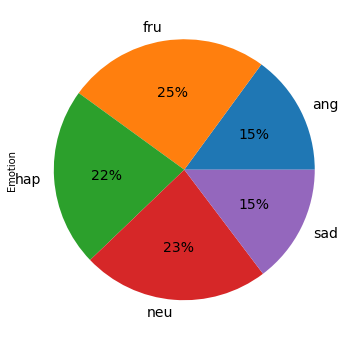

In [16]:
df['Emotion'].value_counts().sort_index().plot(kind='pie', figsize=(6, 6), fontsize=14, autopct=lambda x: f'{x:.0f}%')

## Load Audios to Memory

In [17]:
# Get all filepaths
IEMOCAP_audios = glob('IEMOCAP_audios/*.wav')
print(f'Got {len(IEMOCAP_audios)} audios')

Got 10039 audios


In [18]:
# Test whether stereo to mono convertion via torch.mean works
audio = torch.mean(torchaudio.load(np.random.choice(IEMOCAP_audios))[0], dim=0)
IPython.display.Audio(data=audio, rate=SAMPLING_RATE)

In [19]:
# Get tensors from audios
if os.path.exists('loaded_audios.pt'):
    audios = torch.load('loaded_audios.pt')

else:
    # dict to store Filename -> torch.tensor with audio
    audios = {}

    # function + df.apply to load audios in parallel
    def load_wav(row):
        audios[row['Filename']] = torch.mean(torchaudio.load(row['Filepath'])[0], dim=0, dtype=torch.float32) # taking the mean of both input channels to convert stereo to mono

    _ = df_all.apply(lambda row: load_wav(row), axis='columns')
    torch.save(audios, 'loaded_audios.pt')

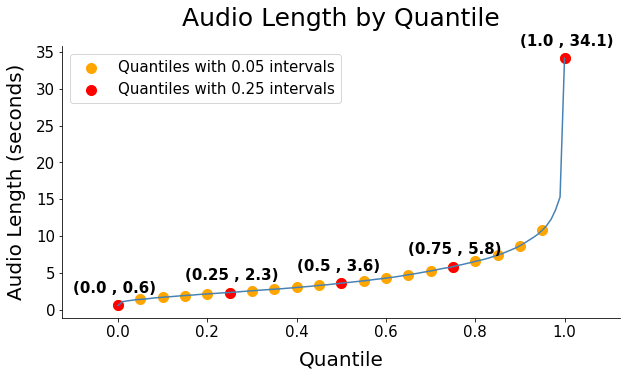

In [24]:
# See audio length distribution
AUDIO_SIZES = [x.shape[0]/SAMPLING_RATE for x in audios.values()]

# Extracting the quantiles
quantiles = pd.Series(AUDIO_SIZES).quantile(np.arange(0, 1.01, 0.01), interpolation='higher')
quantiles.index = [round(idx,2) for idx in quantiles.index]

# Plotting the quantils
fig, ax = plt.subplots(figsize=(10,5))
quantiles.plot(kind='line', color='steelblue', label='')

# Demark the quantiles in increments of 0.05 and 0.25
plt.scatter(x=quantiles.index[::5], y=quantiles.values[::5], c='orange', s=100, label='Quantiles with 0.05 intervals')
plt.scatter(x=quantiles.index[::25], y=quantiles.values[::25], c='red', s=100, label='Quantiles with 0.25 intervals')

# Titles, labels, legend
plt.title('Audio Length by Quantile', size=25, pad=20)
plt.xlabel('Quantile', size=20, labelpad=10)
plt.ylabel('Audio Length (seconds)', size=20, labelpad=10)
plt.legend(loc='best', fontsize=15)

# Axes
plt.xlim([-0.125, 1.125])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=15)

# Annotate the 0th, 25th, 50th, 75th and 100th percentiles
for x, y in zip(quantiles.index[::25], quantiles.values[::25]):
    plt.annotate(s=f'({x} , {y:.1f})', xy=(x,y), xytext=(x-0.1, y+max(quantiles.values)*0.05), fontweight='bold', fontsize=15)

plt.show()

In [23]:
quantiles[0.95]

10.797125

### Sliding Time Window

In [ ]:
# Creating function to calculate the signal envelope 
# Then remove dead spaace from the audio with it
# From empirical testing I found a threshold of about [0.0025, 0.0050] to be the ideal.
def envelope(signal, rate, threshold=0.0025): 
    mask = []
    # pd.Series allows for easy rolling window
    # Need to take abs values otherwise all negative parts of the audio wave would be removed
    y = pd.Series(signal).apply(np.abs)
    # Window size will be a 10th of a second
    y_mean = y.rolling(window = int(rate/10), min_periods = 1, center = True).mean()
    for mean in y_mean:
        if mean > threshold:
            mask.append(True) # Appending true means keep the signal
        else:
            mask.append(False)
    return mask

In [ ]:
# Take an audio, if its longer than MAX_AUDIO_LENGTH, keep only the middle section up to the max length
def get_sliced_audio(audio):

    if audio.shape[0] > MAX_AUDIO_LENGTH:
        extra_length = audio.shape[0] - MAX_AUDIO_LENGTH
        start_idx = int(extra_length // 2)
        end_idx = int(start_idx + MAX_AUDIO_LENGTH)
        audio = audio[start_idx:end_idx]

    return audio

In [ ]:
MelSpectrogram = torchaudio.transforms.MelSpectrogram(SAMPLING_RATE, n_mels=NUM_MELS, n_fft=NUM_MELS, normalized=True, center=False)
MFCC = torchaudio.transforms.MFCC(SAMPLING_RATE, n_mfcc=NUM_MFCCS)
def get_pretrained_timesteps(audio):
    
    # Torch array to hold results in the shape of (timesteps, window_size)
    embedding_features = torch.zeros(size=(TIMESTEPS, EMBEDDING_SIZE), dtype=torch.float32)
    embedding_mask = torch.zeros(size=(TIMESTEPS, EMBEDDING_SIZE), dtype=torch.float32)

    # Ensure audio is not larger than MAX_AUDIO_LENGTH
    audio = get_sliced_audio(audio)

    # Get the number of timesteps for this audio and figure out how many front-padding timesteps to use
    audio_timesteps = int(np.ceil(audio.shape[0]/STEP_SIZE))
    front_padding = TIMESTEPS - audio_timesteps

    # Get pre-trained features for each timestep
    for audio_timestep, embedding_timestep in enumerate(range(front_padding, TIMESTEPS)):

        # Get the timestep's window
        window_start = int(audio_timestep * STEP_SIZE)
        window_end = int(audio_timestep * STEP_SIZE) + EMBEDDING_SIZE
        sliced = audio[window_start: window_end]

        # Get the mask
        mask = torch.zeros(size=(EMBEDDING_SIZE,), dtype=torch.int)
        mask_front_padding = int(len(mask) - len(sliced))
        mask[mask_front_padding:] = torch.ones(size=(len(sliced),), dtype=torch.int)
        embedding_mask[embedding_timestep] = mask

        # Get the embedding
        if PRETRAINED == 'wav2vec2':
            feature_vector = wav2vec2(sliced, sampling_rate=SAMPLING_RATE, attention_mask=mask, do_normalize=True, return_tensors='pt')
            embedding_features[embedding_timestep][mask_front_padding:] = feature_vector['input_values'][0]
        elif PRETRAINED == 'trill':
            feature_vector = torch.tensor(trill(samples=sliced, sample_rate=SAMPLING_RATE)['embedding'].numpy(), dtype=torch.float32)
            embedding_features[embedding_timestep][mask_front_padding:] = feature_vector[0]
        elif PRETRAINED == 'wavlm':
            feature_vector = WavLM(sliced, sampling_rate=SAMPLING_RATE, attention_mask=mask, do_normalize=True, return_tensors='pt')
            embedding_features[embedding_timestep][mask_front_padding:] = feature_vector['input_values'][0]
        elif PRETRAINED == 'melspectrogram':
            tmp = copy.copy(sliced)
            sliced = torch.zeros(size=(EMBEDDING_SIZE,), dtype=torch.float32)
            sliced[mask_front_padding:] = tmp
            melgram = MelSpectrogram(sliced) # has shape (n_mels, timesteps)
            melgram = torch.transpose(melgram, 0, 1).mean(dim=0) # has shape (timesteps, n_mels)
            embedding_features[embedding_timestep] = melgram
        elif PRETRAINED == 'mfcc':
            tmp = copy.copy(sliced)
            sliced = torch.zeros(size=(EMBEDDING_SIZE,), dtype=torch.float32)
            sliced[mask_front_padding:] = tmp
            mfccs = MFCC(sliced) # has shape (n_mels, timesteps)
            mfccs = torch.transpose(mfccs, 0, 1) # has shape (timesteps, n_mels)
            embedding_features[embedding_timestep] = mfccs
        elif PRETRAINED == None:
            embedding_features[embedding_timestep][mask_front_padding:] = sliced
        else:
            raise Exception('PRETRAINED must be one of: wav2vec2, trill, wavlm, melspectrogram, mfcc, None')
        
    return embedding_features, embedding_mask

In [ ]:
print(f'Loading {PRETRAINED} features')
path = f'audios_timesteps_{PRETRAINED}.pt'

# Preload all timesteps to memory
if os.path.exists(path):
    audios_timesteps = torch.load(path)

    # And compute only if some timesteps lack data
    for idx, (filename, audio) in enumerate(tqdm(audios.items())):
        if filename not in set(list(audios_timesteps.keys())):
            audios_timesteps[filename], mask = get_pretrained_timesteps(audio)
            if idx % 100 == 0:
                torch.save(audios_timesteps, path)
    torch.save(audios_timesteps, path)

else:
    audios_timesteps = dict()
    for idx, (filename, audio) in enumerate(tqdm(audios.items())):
        audios_timesteps[filename], mask = get_pretrained_timesteps(audio)
        if idx % 100 == 0:
            torch.save(audios_timesteps, path)
    torch.save(audios_timesteps, path)

Loading wavlm features


100%|██████████| 7529/7529 [00:05<00:00, 1488.17it/s]


## Dataloader


Wav2Vec2 models that have set `config.feat_extract_norm == "group"`, such as [wav2vec2-base](https://huggingface.co/facebook/wav2vec2-base-960h), have **not** been trained using `attention_mask`. For such models, `input_values` should simply be padded with 0 and no `attention_mask` should be passed.  
For Wav2Vec2 models that have set `config.feat_extract_norm == "layer"`, such as [wav2vec2-lv60](https://huggingface.co/facebook/wav2vec2-large-960h-lv60-self), `attention_mask` should be passed for batched inference.

In [ ]:
class ClassifierDataset(torch.utils.data.Dataset):
    
    def __init__(self, 
                 data_table: pd.core.frame.DataFrame, 
                 augment: bool = False):
        
        self.data_table = data_table.reset_index(drop=True)
        self.augment = augment
        if self.augment == True:
            self.augmentor = Compose([#AddGaussianNoise(min_amplitude=0.01, max_amplitude=0.1, p=0.5),
                                      #TimeStretch(min_rate=0.75, max_rate=1.25, p=0.5),
                                       PitchShift(sample_rate=SAMPLING_RATE, p=0.5),
                                       Shift(sample_rate=SAMPLING_RATE, p=0.5),
                                       PolarityInversion(sample_rate=SAMPLING_RATE, p=0.5),
                                       Gain(sample_rate=SAMPLING_RATE, p=0.5)])
        
    def __getitem__(self, idx: int) -> Tuple[torch.tensor, int]:

        # Augment audio and generate feature vectors
        ''' https://pytorch.org/audio/main/sox_effects.html '''
        if self.augment:
            # audio = audios[self.data_table.at[idx, 'Filename']]
            # audio = self.augmentor(audio, SAMPLING_RATE)
            # self.X = get_pretrained_timesteps(audio)

            self.X = audios_timesteps[self.data_table.at[idx, 'Filename']]
            self.X = self.augmentor(self.X.unsqueeze(dim=-0), SAMPLING_RATE)[0]

        # Get preloaded feature vectors
        else:
            self.X = audios_timesteps[self.data_table.at[idx, 'Filename']]

        # Get label
        label = self.data_table.at[idx, 'Emotion']
        self.y = label_to_idx[label]

        return self.X, self.y
        
    def __len__ (self):
        return len(self.data_table)

In [ ]:
# Datasets
train_dataset = ClassifierDataset(df_train, augment = True)
valid_dataset = ClassifierDataset(df_valid)
test_dataset = ClassifierDataset(df_test)

train_dataset = ClassifierDataset(pd.concat([df_train, df_valid, df_test]), augment = False)

In [ ]:
# Weighted sampling
weighted_sampler = torch.utils.data.WeightedRandomSampler(weights = class_weights,
                                                          num_samples = len(train_dataset),
                                                          replacement = True)

In [ ]:
# Data loaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size = BATCH_SIZE,
                                           sampler = None,
                                           shuffle = True)
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                           batch_size = BATCH_SIZE)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size = BATCH_SIZE)

## Model

In [ ]:
class AudioNN(nn.Module):

    def __init__(self, 
                 input_size: int, 
                 num_classes: int, 
                 weight: torch.tensor = None, 
                 device: str = 'cpu'):
        
        super(AudioNN, self).__init__()
        self.num_classes = num_classes
        self.weight = weight
        self.device = device

        # Layers
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        
        self.lstm1 = nn.LSTM(input_size//1, input_size//2, bidirectional=True, batch_first=True)
        self.batchnorm1 = nn.BatchNorm1d(TIMESTEPS)
        self.layernorm1 = nn.LayerNorm([TIMESTEPS, input_size//1])
        # self.instancenorm1 = nn.InstanceNorm1d(TIMESTEPS, affine=True)
        self.dropout1 = nn.Dropout(0.7)

        self.lstm2 = nn.LSTM(input_size, input_size//2, bidirectional=False, batch_first=True)
        self.batchnorm2 = nn.BatchNorm1d(input_size//2)
        self.layernorm2 = nn.LayerNorm(input_size//2)
        # self.instancenorm2 = nn.InstanceNorm1d(input_size//2, affine=True)
        self.dropout2 = nn.Dropout(0.7)

        self.fc3 = nn.Linear(input_size//2, input_size//2)   
        self.batchnorm3 = nn.BatchNorm1d(input_size//2)
        self.layernorm3 = nn.LayerNorm(input_size//2)
        # self.instancenorm3 = nn.InstanceNorm1d(input_size//2, affine=True)
        self.dropout3 = nn.Dropout(0.7)

        self.fc4 = nn.Linear(input_size//2, num_classes)      

        if type(self.weight) == torch.Tensor: self.loss_func = nn.CrossEntropyLoss(weight=weight.to(self.device)).to(self.device)
        else: self.loss_func = nn.CrossEntropyLoss().to(self.device)
        self.optimizer = AdaBelief(self.parameters(), lr=1e-3, eps=1e-12, betas=(0.9,0.999), rectify=False, print_change_log=False)

        # Track loss improvements over epochs
        self.best_loss = float('inf')

    # x represents our data
    def forward(self, x):
        x, (h_0, c_0) = self.lstm1(x)
        x = self.layernorm1(x)
        x = self.relu(x) 
        x = self.dropout1(x)

        x, (h_1, c_1) = self.lstm2(x)
        x = x[:, -1, :] # equivalent of return_sequences = False
        x = self.layernorm2(x)
        x = self.relu(x) 
        x = self.dropout2(x)

        # x = self.fc3(x)
        # x = self.batchnorm3(x)
        # x = self.relu(x)
        # x = self.dropout3(x)

        x = self.fc4(x)
        output = nn.functional.softmax(x, dim=1)
        return output

    # Return a dictionary with the total number of parameters
    def get_num_parameters(self):
        total_params = sum(p.numel() for p in self.parameters())
        trainable_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        return {'total_parameters': total_params, 'trainable_parameters': trainable_params}

    def fit(self, 
            train_loader: torch.utils.data.dataloader.DataLoader, 
            valid_loader: torch.utils.data.dataloader.DataLoader = None, 
            epochs = 50, 
            print_data = False,
            model_name = None):
        self.model_name = model_name
        
        for epoch in range(epochs):
            start_time = time.time()
            truth_onehot_train = np.ndarray(shape=(0, self.num_classes))
            proba_onehot_train = np.ndarray(shape=(0, self.num_classes))
            LOSS_train, ACC_train, F1_train, ROC_AUC_train = 0.0, 0.0, 0.0, 0.0

            # Training data
            self.train()
            for j, data in enumerate(train_loader):

                # Get the inputs; data is a list of [inputs, labels]
                X, y = data
                X = X.to(self.device)
                y = y.to(self.device)               

                # Forward (aka predict)
                pred_probas = self.forward(X)
                pred_labels = torch.argmax(pred_probas, dim=1)

                # Loss
                loss = self.loss_func(pred_probas, y)
                LOSS_train += loss.item()
                
                # Back propagation
                self.optimizer.zero_grad()
                loss.backward() # back progragation
                self.optimizer.step() # gradient descent

                # Store Predictions
                batch_onehot_truth = OHE.transform(y.detach().cpu().numpy().reshape(-1, 1))
                truth_onehot_train = np.concatenate((truth_onehot_train, batch_onehot_truth))
                batch_onehot_proba = pred_probas.detach().cpu().numpy()
                proba_onehot_train = np.concatenate((proba_onehot_train, batch_onehot_proba))

            # Get epoch metrics
            LOSS_train /= len(train_loader)
            ACC_train, F1_train, ROC_AUC_train = self._get_metrics(truth_onehot_train, proba_onehot_train)

            # Evaluate on validation set + Early Stopping
            if valid_loader is not None:
                LOSS_valid, ACC_valid, F1_valid, ROC_AUC_valid = self._evaluate(valid_loader)
                if self._check_early_stop(LOSS_valid): break
            else:
                if self._check_early_stop(LOSS_train): break
            
            # At the end of epoch, print metrics
            if valid_loader is not None:
                print(f'EPOCH: {epoch+1:>3}' + '   |   '  + 
                      f'LOSS: Train = {LOSS_train:.4f}   Valid = {LOSS_valid:.4f}' + '   |   '  + 
                      f'ACCURACY: Train = {ACC_train:.4f}   Valid = {ACC_valid:.4f}' + '   |   '  + 
                      f'F1 SCORE: Train = {F1_train:.4f}   Valid = {F1_valid:.4f}' + '   |   '  + 
                      f'ROC-AUC: Train = {ROC_AUC_train:.4f}   Valid = {ROC_AUC_valid:.4f}' + '   |   '  + 
                      f'DURATION: {(time.time() - start_time):.0f} seconds')
            else:
                print(f'EPOCH: {epoch+1:>3}' + '   |   '  + 
                      f'LOSS: Train = {LOSS_train:.4f}' + '   |   '  + 
                      f'ACCURACY: Train = {ACC_train:.4f}' + '   |   '  + 
                      f'F1 SCORE: Train = {F1_train:.4f}' + '   |   '  + 
                      f'ROC-AUC: Train = {ROC_AUC_train:.4f}' + '   |   '  + 
                      f'DURATION: {(time.time() - start_time):.0f} seconds')

    def _check_early_stop(self, LOSS):
        if LOSS < self.best_loss:
            self.best_loss = LOSS
            if type(self.model_name) == str: torch.save(self, self.model_name)
            self.patience = 20
            return False
        else:
            self.patience -= 1
            if self.patience <= 0:
                print('Early Stopping')
                return True

    def _evaluate(self, 
                  valid_loader: torch.utils.data.dataloader.DataLoader):
        # Validation data
        self.eval()
        with torch.no_grad():

            truth_onehot_valid = np.ndarray(shape=(0, self.num_classes))
            proba_onehot_valid = np.ndarray(shape=(0, self.num_classes))
            LOSS_valid, ACC_valid, F1_valid, ROC_AUC_valid = 0.0, 0.0, 0.0, 0.0

            for k, data in enumerate(valid_loader):

                # Get the inputs; data is a list of [inputs, labels]
                X, y = data
                X = X.to(self.device)
                y = y.to(self.device)

                # Forward (aka predict)
                pred_probas = self.forward(X)

                # Loss
                loss = self.loss_func(pred_probas, y)
                LOSS_valid += loss.item()

                # Store Predictions
                batch_onehot_truth = OHE.transform(y.detach().cpu().numpy().reshape(-1, 1))
                truth_onehot_valid = np.concatenate((truth_onehot_valid, batch_onehot_truth))
                batch_onehot_proba = pred_probas.detach().cpu().numpy()
                proba_onehot_valid = np.concatenate((proba_onehot_valid, batch_onehot_proba))

            # Get epoch metrics
            LOSS_valid /= len(valid_loader)
            ACC_valid, F1_valid, ROC_AUC_valid = self._get_metrics(truth_onehot_valid, proba_onehot_valid)

        return LOSS_valid, ACC_valid, F1_valid, ROC_AUC_valid

    def _get_metrics(self, true_onehot, pred_probas):
        true_labels = np.argmax(true_onehot, axis=-1)
        pred_labels = np.argmax(pred_probas, axis=-1)
        acc = accuracy_score(y_true=true_labels, y_pred=pred_labels)
        f1 = f1_score(y_true=true_labels, y_pred=pred_labels, average='macro')
        roc = roc_auc_score(y_true=true_onehot, y_score=pred_probas)
        return acc, f1, roc

    # Predict labels
    def predict(self, 
                test_loader:torch.utils.data.dataloader.DataLoader):
        # Test data
        self.eval()
        with torch.no_grad():
            output = list()

            for _, data in enumerate(test_loader):

                # Get the inputs; data is a list of [inputs, labels]
                X, y = data
                X = X.to(self.device)
                y = y.to(self.device)

                # Forward (aka predict)
                pred_probas = self.forward(X)
                pred_labels = np.argmax(pred_probas.detach().cpu(), axis=-1)

                # Append to output
                pred_labels = pred_labels.tolist()
                output.extend(pred_labels)
            
        return output

    # Predict probabilities
    def predict_probas(self, 
                       test_loader:torch.utils.data.dataloader.DataLoader):
        # Test data
        self.eval()
        with torch.no_grad():
            output = list()

            for _, data in enumerate(test_loader):

                # Get the inputs; data is a list of [inputs, labels]
                X, y = data
                X = X.to(self.device)
                y = y.to(self.device)

                # Forward (aka predict)
                pred_probas = self.forward(X)

                # Append to output
                output.extend(pred_probas.tolist())
            
        return output

## Training

In [ ]:
model = AudioNN(input_size = EMBEDDING_SIZE, 
                num_classes = len(class_names),
                weight = class_weights,
                device = DEVICE)
model.to(DEVICE)

Weight decoupling enabled in AdaBelief


AudioNN(
  (relu): ReLU()
  (tanh): Tanh()
  (lstm1): LSTM(400, 200, batch_first=True, bidirectional=True)
  (batchnorm1): BatchNorm1d(600, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layernorm1): LayerNorm((600, 400), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.7, inplace=False)
  (lstm2): LSTM(400, 200, batch_first=True)
  (batchnorm2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layernorm2): LayerNorm((200,), eps=1e-05, elementwise_affine=True)
  (dropout2): Dropout(p=0.7, inplace=False)
  (fc3): Linear(in_features=200, out_features=200, bias=True)
  (batchnorm3): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layernorm3): LayerNorm((200,), eps=1e-05, elementwise_affine=True)
  (dropout3): Dropout(p=0.7, inplace=False)
  (fc4): Linear(in_features=200, out_features=5, bias=True)
  (loss_func): CrossEntropyLoss()
)

In [ ]:
model.fit(train_loader = train_loader,
          valid_loader = valid_loader,
          epochs = 200,
          model_name = None)

EPOCH:   1   |   LOSS: Train = 1.6114   Valid = 1.5742   |   ACCURACY: Train = 0.2046   Valid = 0.2635   |   F1 SCORE: Train = 0.2011   Valid = 0.1842   |   ROC-AUC: Train = 0.5153   Valid = 0.6207   |   DURATION: 22 seconds
EPOCH:   2   |   LOSS: Train = 1.5753   Valid = 1.6085   |   ACCURACY: Train = 0.2394   Valid = 0.1958   |   F1 SCORE: Train = 0.2213   Valid = 0.1457   |   ROC-AUC: Train = 0.5818   Valid = 0.6210   |   DURATION: 21 seconds
EPOCH:   3   |   LOSS: Train = 1.5688   Valid = 1.5205   |   ACCURACY: Train = 0.2398   Valid = 0.3042   |   F1 SCORE: Train = 0.2225   Valid = 0.2737   |   ROC-AUC: Train = 0.5912   Valid = 0.6702   |   DURATION: 22 seconds
EPOCH:   4   |   LOSS: Train = 1.5305   Valid = 1.5070   |   ACCURACY: Train = 0.2851   Valid = 0.2993   |   F1 SCORE: Train = 0.2696   Valid = 0.2654   |   ROC-AUC: Train = 0.6322   Valid = 0.6943   |   DURATION: 22 seconds
EPOCH:   5   |   LOSS: Train = 1.5470   Valid = 1.5830   |   ACCURACY: Train = 0.2839   Valid = 0.21

KeyboardInterrupt: ignored

## Evaluate Model

In [ ]:
model = torch.load(f="acoustic_wavlm.pt")
pd.options.display.float_format = "{:,.2f}".format

#### Test

In [ ]:
# Evaluate on test data
truth_test = df_test['Emotion'].map(label_to_idx)

# Accuracy
preds_test = model.predict(test_loader)
probas_test = np.array(model.predict_probas(test_loader))
labels_test = pd.Series(preds_test, name='Predictions').map(idx_to_label)
output = pd.concat([df_test[['Filename', 'Gender', 'Emotion']].reset_index(drop=True), labels_test], axis='columns')
output.to_csv('Predictions_Acoustic.csv', index=False)

# {'anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise'}
onehot_encoder = OneHotEncoder(sparse=False)
true_onehot = onehot_encoder.fit_transform(np.array(truth_test).reshape(-1, 1))
pred_onehot = onehot_encoder.transform(np.array(preds_test).reshape(-1, 1))

# Metrics
ACC_test = accuracy_score(true_onehot, pred_onehot)
print(f'Test Accuracy: {ACC_test:.5f}')
F1_test = f1_score(true_onehot, pred_onehot, average='macro')
print(f'Test F1 Macro: {F1_test:.5f}')
ROC_test = roc_auc_score(true_onehot, pred_onehot)
print(f'ROC AUC: {ROC_test:.5f}')

Test Accuracy: 0.67778
Test F1 Macro: 0.68100
ROC AUC: 0.80665


In [ ]:
output

,Filename,Gender,Emotion,Predictions
0,Ses05M_script03_2_F001,M,neu,hap
1,Ses05M_script03_2_F003,M,fru,fru
2,Ses05M_script03_2_F005,M,neu,neu
3,Ses05M_script03_2_F009,M,neu,neu
4,Ses05M_script03_2_F013,M,fru,neu
...,...,...,...,...
805,Ses05F_script01_1_M025,F,ang,ang
806,Ses05F_script01_1_M029,F,fru,fru
807,Ses05F_script01_1_M031,F,fru,hap
808,Ses05F_script01_1_M033,F,fru,fru


In [ ]:
# Predictions
pred_label_counts = pd.Series(preds_test).value_counts().sort_index()
pred_label_counts.index = pred_label_counts.index.map(idx_to_label)
pred_label_counts = pred_label_counts/sum(pred_label_counts * 10e-3)
pred_label_counts.name = 'Predicted'

# Truth
truth_label_counts = pd.Series(truth_test).value_counts().sort_index()
truth_label_counts.index = truth_label_counts.index.map(idx_to_label)
truth_label_counts = truth_label_counts/sum(truth_label_counts * 10e-3)
truth_label_counts.name = 'Truth'

# Merge and calculate error
test_errors = pd.concat([pred_label_counts, truth_label_counts], axis='columns')
test_errors['Total Error'] = test_errors['Predicted'] - test_errors['Truth']
test_errors['Percentage Error'] = 100*(test_errors['Predicted'] - test_errors['Truth']) / test_errors['Truth']
test_errors

,Predicted,Truth,Total Error,Percentage Error
ang,14.81,10.86,3.95,36.36
fru,28.77,22.72,6.05,26.63
hap,28.40,28.64,-0.25,-0.86
neu,14.94,22.59,-7.65,-33.88
sad,13.09,15.19,-2.10,-13.82


## Confusion Matrix

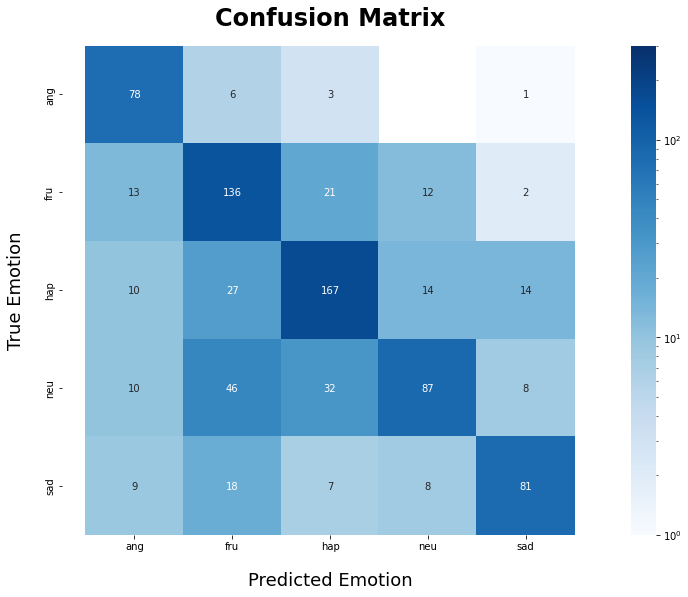

In [ ]:
conf_mat = confusion_matrix(truth_test, preds_test)#, labels=class_names)
df_cm = pd.DataFrame(conf_mat, index = class_names,
                     columns = class_names)
plt.figure(figsize = (12,9))
plt.title('Confusion Matrix', fontsize = 24, pad = 20, fontweight='bold')
sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='g', norm=LogNorm(vmax=300))
plt.ylabel('True Emotion', fontsize = 18, labelpad = 20)
plt.xlabel('Predicted Emotion', fontsize = 18, labelpad = 20)
plt.axis('equal')
plt.show()

## ROC

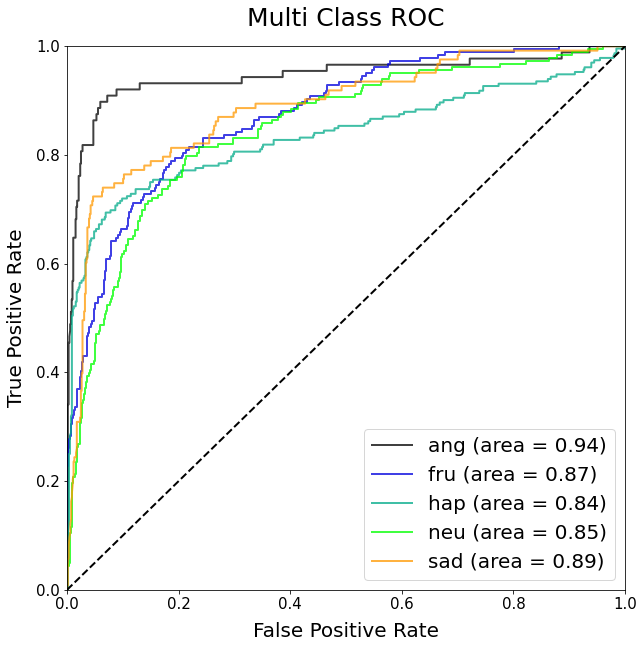

In [ ]:
# Data for the plots
N_CLASSES = len(class_names)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(N_CLASSES):
    fpr[i], tpr[i], _ = roc_curve(true_onehot[:, i], probas_test[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# ROC-AUC Plot: Class Scores
fig, ax = plt.subplots(figsize=(10,10))
colors = []
cm = pylab.get_cmap('nipy_spectral')
for i in range(N_CLASSES):
    color = cm(1.*i/N_CLASSES)
    colors.append(color)

for i, color in zip(range(N_CLASSES), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, alpha=0.75,
             label='{0} (area = {1:0.2f})'.format(class_names[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
ax.tick_params(axis='both', which='major', labelsize=15)
plt.xlabel('False Positive Rate', fontsize=20, labelpad=10)
plt.ylabel('True Positive Rate', fontsize=20, labelpad=10)
plt.title('Multi Class ROC', fontsize=25, pad=20)
plt.legend(fontsize=20, loc="lower right")
plt.show()

# End